# Sheet 6

## 1 Autoencoders: theory and practice

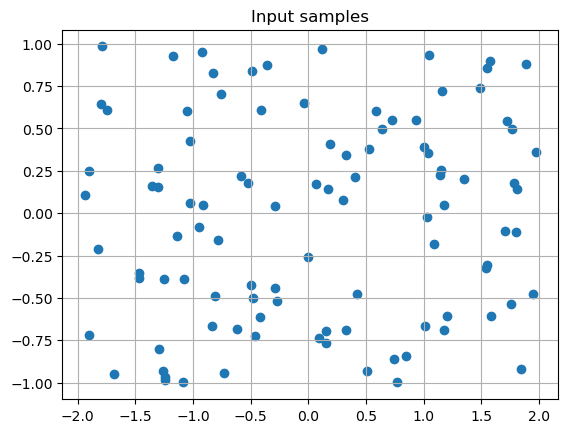

In [1]:
import torch
import matplotlib.pyplot as plt

# create 100 uniform samples from a rectangle [-2, 2] x [-1, 1]
num_samples = 100
data = torch.zeros(num_samples, 2)
data[:, 0] = torch.rand(num_samples) * 4 - 2
data[:, 1] = torch.rand(num_samples) * 2 - 1

# plot the samples
plt.scatter(data[:, 0], data[:, 1])
plt.title("Input samples")
plt.grid(True)
plt.show()

In [2]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loader
dataset = TensorDataset(data, data)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True, drop_last=True)

# get batched data from the data loader
x, y = next(iter(data_loader))
print("x.shape:", x.shape)
print("y.shape:", y.shape)
print("all x == y:", torch.all(x == y).item())

x.shape: torch.Size([8, 2])
y.shape: torch.Size([8, 2])
all x == y: True


In [3]:
# TODO: define the Autoencoder architecture

import torch
from torch import nn
import pytorch_lightning as pl
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self, hidden_channels, latent_dim=1, input_dim=2):
        super(Autoencoder, self).__init__()
        
        # TODO: implement the encoder and decoder
        if hidden_channels[0]==0:
            self.encoder = nn.Linear(input_dim,latent_dim,bias = False)
            self.decoder = nn.Linear(latent_dim,input_dim,bias = False)       
    
        else:
            e_modules = []
            d_modules = []
            current_dim = input_dim
            for hidded_channels in hidden_channels:
                e_modules.append(nn.Linear(current_dim, hidded_channels))
                e_modules.append(nn.ReLU())
                current_dim = hidded_channels
            e_modules.append(nn.Linear(current_dim, latent_dim))
            e_modules.append(nn.ReLU())
    
            self.encoder = nn.Sequential(*e_modules)
            current_dim = latent_dim
            for hidded_channels in hidden_channels[::-1]:
                d_modules.append(nn.Linear(current_dim, hidded_channels))
                d_modules.append(nn.ReLU())
                current_dim = hidded_channels
            d_modules.append(nn.Linear(current_dim,input_dim))
            self.decoder = nn.Sequential(*d_modules)
        #print(encoder,decoder)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class AutoencoderModule(pl.LightningModule):
    def __init__(self, **model_kwargs):
        super().__init__()
        self.autoencoder = Autoencoder(**model_kwargs)
        self.loss_curve = []

    def forward(self, x):
        return self.autoencoder(x)

    def configure_optimizers(self):
        # as default use Adam optimizer:
        optimizer = torch.optim.Adam(self.parameters())

        return optimizer
    
    def on_train_start(self):
        self.loss_curve = []
        return super().on_train_start()

    def training_step(self, batch):
        x, _ = batch
        x_hat = self.autoencoder(x)
        loss = nn.MSELoss()(x_hat, x)
        self.loss_curve.append(loss.item())
        return loss






In [5]:
hidden_channels_list = [[20,10],[50,50,50],[0]]

trained_modules = {}
initial_weights = []
final_weights = []
for i in range(len(hidden_channels_list)):
    hidden_channels = hidden_channels_list[i]
    autoencoder_module= AutoencoderModule(hidden_channels=hidden_channels)  # TODO: specify the model here
    # start the training using a PyTorch Lightning Trainer
    # Saving weights manually before training
    print(i)
    initial_weights.append(autoencoder_module.state_dict())
    print(initial_weights)
    trainer2 = pl.Trainer(max_epochs=1, enable_checkpointing=True)#,resume_from_checkpoint=None)
    print("Model overview:", autoencoder_module)
    trained_modules["autoencoder{0}".format(i)]=autoencoder_module
    trainer2.fit(autoencoder_module, data_loader)
    final_weights.append(autoencoder_module.state_dict())
    print(final_weights)


0
[OrderedDict([('autoencoder.encoder.0.weight', tensor([[ 0.3503,  0.6566],
        [-0.4261,  0.1105],
        [ 0.3896, -0.1150],
        [ 0.5305, -0.4792],
        [ 0.3879,  0.3351],
        [-0.0795, -0.4968],
        [-0.6817,  0.5843],
        [-0.4091, -0.6166],
        [-0.4357,  0.4110],
        [ 0.1303,  0.1468],
        [-0.0175, -0.5866],
        [ 0.1818, -0.6854],
        [ 0.4736, -0.6610],
        [ 0.4997, -0.3436],
        [ 0.4804, -0.6609],
        [ 0.5752, -0.2619],
        [-0.6527, -0.2075],
        [-0.0586, -0.0569],
        [ 0.0417, -0.6159],
        [ 0.0318, -0.6308]])), ('autoencoder.encoder.0.bias', tensor([ 0.0066, -0.7029,  0.7061, -0.6004, -0.2141,  0.6262, -0.5474,  0.5489,
         0.6159, -0.5546,  0.2130,  0.6915,  0.4111,  0.6828, -0.0285, -0.3308,
        -0.6763, -0.4835,  0.4001,  0.5335])), ('autoencoder.encoder.2.weight', tensor([[ 0.2206, -0.0394,  0.0147,  0.0514, -0.1657, -0.1094,  0.1265, -0.0248,
         -0.0517,  0.1417,  0.1823, 

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\Thanu\anaconda3\envs\mlph3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 563    | train
----------------------------------------------------
563       Trainable params
0         Non-trainable params
563       Total params
0.002     Total estimated model params size (MB)


Model overview: AutoencoderModule(
  (autoencoder): Autoencoder(
    (encoder): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): ReLU()
      (2): Linear(in_features=20, out_features=10, bias=True)
      (3): ReLU()
      (4): Linear(in_features=10, out_features=1, bias=True)
      (5): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): ReLU()
      (2): Linear(in_features=10, out_features=20, bias=True)
      (3): ReLU()
      (4): Linear(in_features=20, out_features=2, bias=True)
    )
  )
)


C:\Users\Thanu\anaconda3\envs\mlph3\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
C:\Users\Thanu\anaconda3\envs\mlph3\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (12) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 10.6 K | train
----------------------------------------------------
10.6 K    Trainable params
0         Non-trainable params
10.6 K    Total params
0.042     Total estimated model params size (MB)


[OrderedDict([('autoencoder.encoder.0.weight', tensor([[ 0.3432,  0.6654],
        [-0.4224,  0.1158],
        [ 0.3946, -0.1043],
        [ 0.5351, -0.4869],
        [ 0.3887,  0.3403],
        [-0.0903, -0.5085],
        [-0.6772,  0.5944],
        [-0.4196, -0.6276],
        [-0.4453,  0.4000],
        [ 0.1303,  0.1468],
        [-0.0074, -0.5753],
        [ 0.1714, -0.6864],
        [ 0.4769, -0.6642],
        [ 0.5068, -0.3404],
        [ 0.4830, -0.6519],
        [ 0.5758, -0.2555],
        [-0.6431, -0.1996],
        [-0.0586, -0.0569],
        [ 0.0398, -0.6260],
        [ 0.0214, -0.6417]])), ('autoencoder.encoder.0.bias', tensor([ 0.0160, -0.7064,  0.7033, -0.5939, -0.2144,  0.6338, -0.5486,  0.5582,
         0.6203, -0.5546,  0.2033,  0.6861,  0.4079,  0.6751, -0.0365, -0.3320,
        -0.6853, -0.4835,  0.4036,  0.5438])), ('autoencoder.encoder.2.weight', tensor([[ 0.2315, -0.0393,  0.0253,  0.0566, -0.1571, -0.1044,  0.1329, -0.0246,
         -0.0444,  0.1417,  0.1764, -0

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name        | Type        | Params | Mode 
----------------------------------------------------
0 | autoencoder | Autoencoder | 4      | train
----------------------------------------------------
4         Trainable params
0         Non-trainable params
4         Total params
0.000     Total estimated model params size (MB)


[OrderedDict([('autoencoder.encoder.0.weight', tensor([[ 0.3432,  0.6654],
        [-0.4224,  0.1158],
        [ 0.3946, -0.1043],
        [ 0.5351, -0.4869],
        [ 0.3887,  0.3403],
        [-0.0903, -0.5085],
        [-0.6772,  0.5944],
        [-0.4196, -0.6276],
        [-0.4453,  0.4000],
        [ 0.1303,  0.1468],
        [-0.0074, -0.5753],
        [ 0.1714, -0.6864],
        [ 0.4769, -0.6642],
        [ 0.5068, -0.3404],
        [ 0.4830, -0.6519],
        [ 0.5758, -0.2555],
        [-0.6431, -0.1996],
        [-0.0586, -0.0569],
        [ 0.0398, -0.6260],
        [ 0.0214, -0.6417]])), ('autoencoder.encoder.0.bias', tensor([ 0.0160, -0.7064,  0.7033, -0.5939, -0.2144,  0.6338, -0.5486,  0.5582,
         0.6203, -0.5546,  0.2033,  0.6861,  0.4079,  0.6751, -0.0365, -0.3320,
        -0.6853, -0.4835,  0.4036,  0.5438])), ('autoencoder.encoder.2.weight', tensor([[ 0.2315, -0.0393,  0.0253,  0.0566, -0.1571, -0.1044,  0.1329, -0.0246,
         -0.0444,  0.1417,  0.1764, -0

Training: |                                                                                      | 0/? [00:00<…

`Trainer.fit` stopped: `max_epochs=1` reached.


[OrderedDict([('autoencoder.encoder.0.weight', tensor([[ 0.3432,  0.6654],
        [-0.4224,  0.1158],
        [ 0.3946, -0.1043],
        [ 0.5351, -0.4869],
        [ 0.3887,  0.3403],
        [-0.0903, -0.5085],
        [-0.6772,  0.5944],
        [-0.4196, -0.6276],
        [-0.4453,  0.4000],
        [ 0.1303,  0.1468],
        [-0.0074, -0.5753],
        [ 0.1714, -0.6864],
        [ 0.4769, -0.6642],
        [ 0.5068, -0.3404],
        [ 0.4830, -0.6519],
        [ 0.5758, -0.2555],
        [-0.6431, -0.1996],
        [-0.0586, -0.0569],
        [ 0.0398, -0.6260],
        [ 0.0214, -0.6417]])), ('autoencoder.encoder.0.bias', tensor([ 0.0160, -0.7064,  0.7033, -0.5939, -0.2144,  0.6338, -0.5486,  0.5582,
         0.6203, -0.5546,  0.2033,  0.6861,  0.4079,  0.6751, -0.0365, -0.3320,
        -0.6853, -0.4835,  0.4036,  0.5438])), ('autoencoder.encoder.2.weight', tensor([[ 0.2315, -0.0393,  0.0253,  0.0566, -0.1571, -0.1044,  0.1329, -0.0246,
         -0.0444,  0.1417,  0.1764, -0

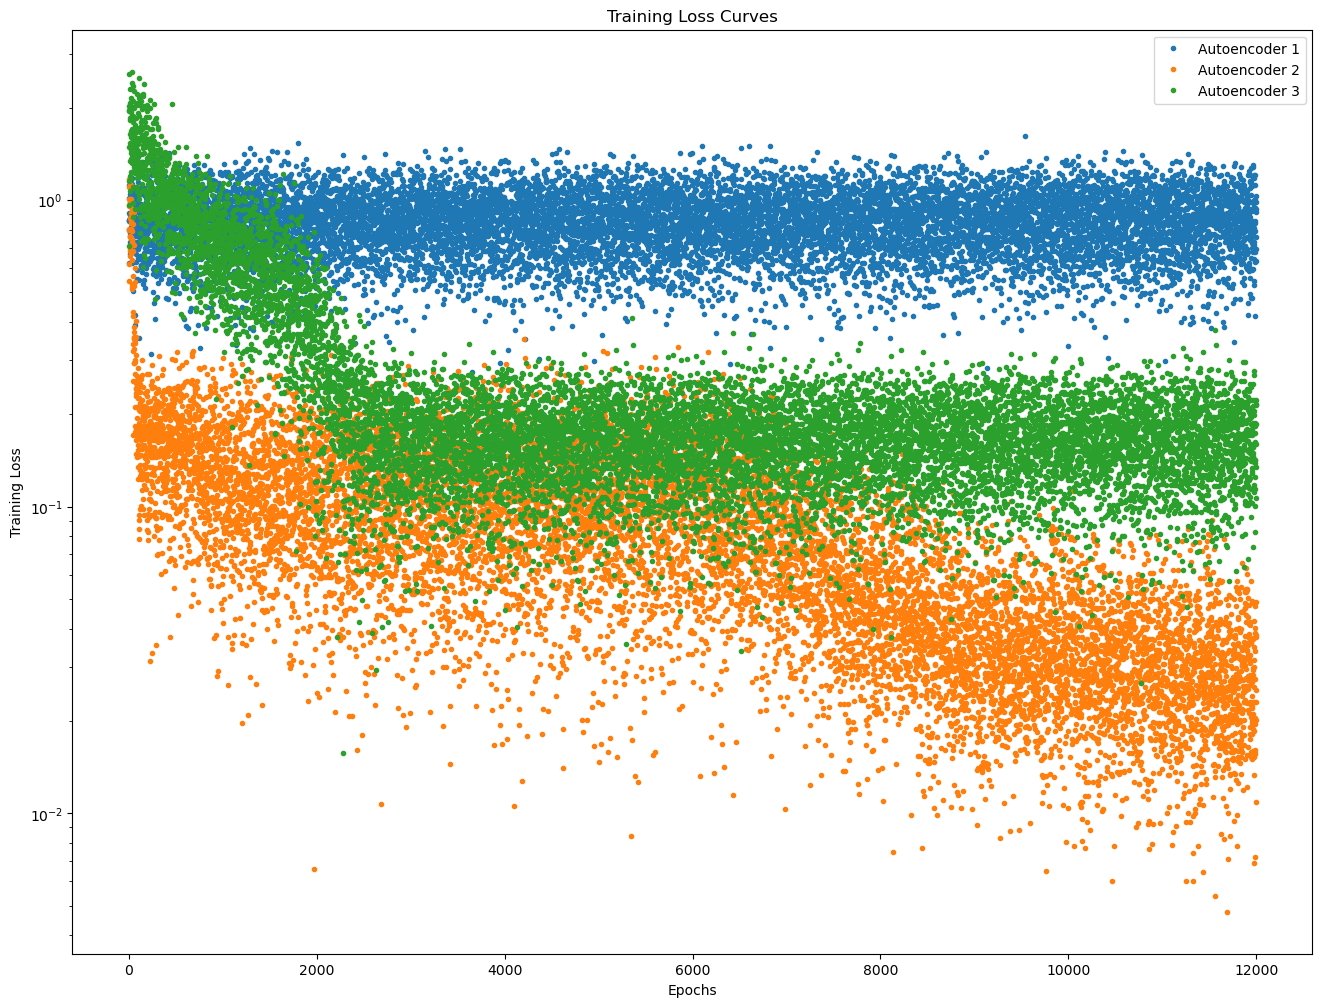

In [5]:
#print(trained_modules)
#print(trained_modules["autoencoder1"].loss_curve)
# Plot Training Loss Curves
plt.figure(figsize=(16,12))

for i, model in enumerate(trained_modules):
    #plt.subplot(3,1,i+1)
    losses = trained_modules[model].loss_curve
    plt.plot(range(len(losses)), losses, '.',label=f'Autoencoder {i+1}')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.yscale('log')
plt.title('Training Loss Curves')
plt.legend()
plt.show()


tensor(0., grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MinBackward1>)


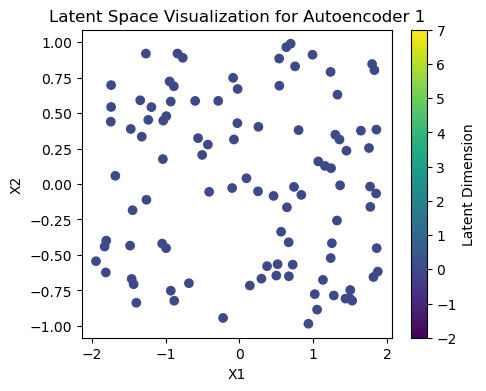

tensor(5.7078, grad_fn=<MaxBackward1>)
tensor(0., grad_fn=<MinBackward1>)


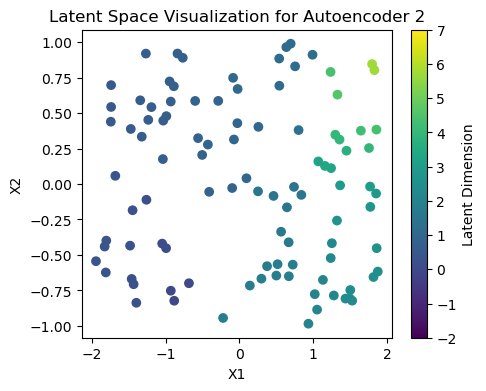

tensor(1.6682, grad_fn=<MaxBackward1>)
tensor(-1.6704, grad_fn=<MinBackward1>)


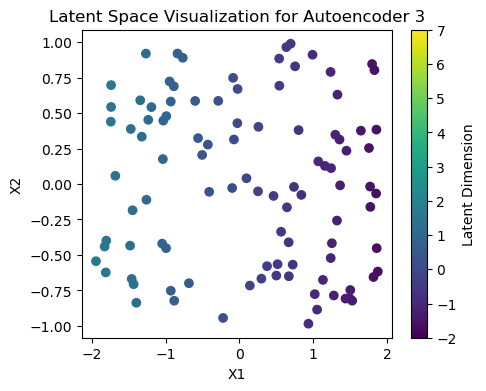

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as mtc
# Visualize Latent Embeddings for Each Model
for i, model in enumerate(trained_modules):
   # print(trained_modules[model](data))
    latent = trained_modules[model].autoencoder.encoder(data)
    print(torch.max(latent))
    print(torch.min(latent))
    #print(latent)# Encode input data
    latent = latent.detach().numpy()
    plt.figure(figsize=(5, 4))
    normalize = mtc.Normalize(vmin=-2, vmax=7)
    scatter = plt.scatter(data[:, 0], data[:, 1], c=latent[:, 0], cmap='viridis',norm=normalize)
    plt.colorbar(scatter, label='Latent Dimension')#,vmin=-2,vmax=7)
    plt.title(f'Latent Space Visualization for Autoencoder {i + 1}')
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.show()


a
OrderedDict([('autoencoder.encoder.0.weight', tensor([[-0.3016,  0.4840],
        [ 0.0896,  0.6710],
        [-0.7068, -0.1923],
        [-0.3226, -0.3060],
        [ 0.1764, -0.4795],
        [ 0.0668,  0.5985],
        [ 0.6610,  0.2083],
        [-0.6340,  0.0822],
        [-0.2533, -0.3853],
        [ 0.2849,  0.2082],
        [ 0.5373,  0.5180],
        [ 0.6785, -0.0859],
        [ 0.1484,  0.1925],
        [ 0.1966, -0.5032],
        [-0.1271, -0.4604],
        [ 0.7023,  0.1633],
        [-0.1346, -0.6179],
        [ 0.2139,  0.6868],
        [ 0.5311,  0.3892],
        [-0.1855, -0.6360]])), ('autoencoder.encoder.0.bias', tensor([-0.0481,  0.3427,  0.4806, -0.3719,  0.6567, -0.3792,  0.4339,  0.7024,
         0.4138,  0.5174, -0.0335, -0.2249, -0.5566, -0.1883,  0.3382, -0.6693,
         0.0653,  0.2677, -0.6071, -0.3131])), ('autoencoder.encoder.2.weight', tensor([[ 0.0429, -0.0985,  0.0762,  0.0153, -0.0261, -0.0866, -0.1188,  0.0523,
          0.1015, -0.1288, -0.0033, -

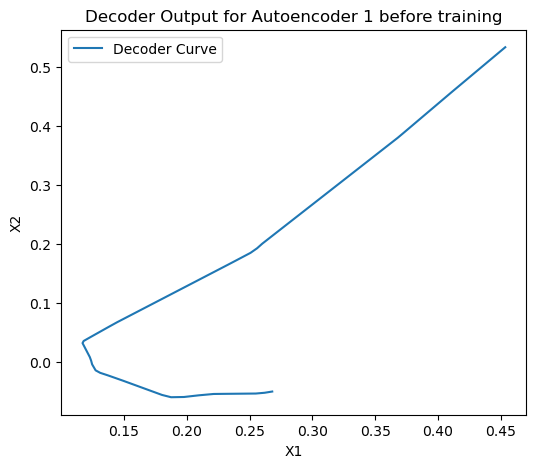

0
OrderedDict([('autoencoder.encoder.0.weight', tensor([[-0.4229,  0.6548],
        [ 0.7343, -0.5580],
        [-0.0364,  0.0498],
        [ 0.1205, -0.1327],
        [ 0.5067,  0.3127],
        [-0.2822, -0.2009],
        [-0.2283, -0.3643],
        [ 0.6619,  0.5282],
        [-0.4332,  0.0354],
        [-0.2911,  0.0271],
        [ 0.2611, -0.1135],
        [ 0.5278, -0.1892],
        [-0.1149,  0.2406],
        [ 0.1279,  0.1468],
        [-0.0906, -0.4916],
        [ 0.0252,  0.1531],
        [ 0.0958, -0.4142],
        [-0.5635,  0.0866],
        [ 0.1874,  0.4248],
        [ 0.8985,  0.1395],
        [-0.5707, -0.5479],
        [-0.0285, -0.5225],
        [-0.3849, -0.2426],
        [-0.1567, -0.6872],
        [ 0.4911,  0.4915],
        [ 0.2727,  0.2096],
        [-0.6452,  0.1945],
        [ 0.2654, -0.1196],
        [-0.4906,  0.6833],
        [-0.0722,  1.0094],
        [-0.0670, -0.6906],
        [-0.4651,  0.1300],
        [-0.0462,  0.1945],
        [ 0.5555,  0.2327],


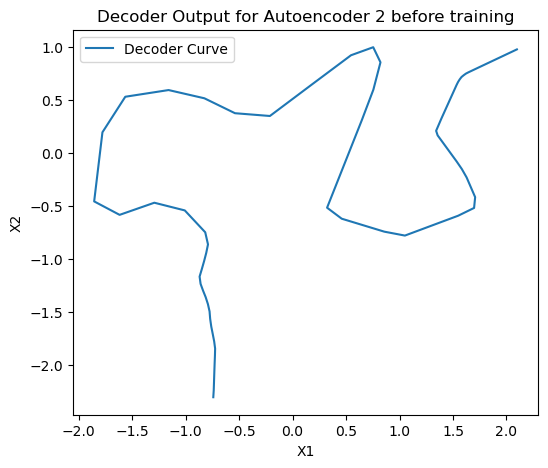

0
OrderedDict([('autoencoder.encoder.weight', tensor([[-0.8738,  0.0524]])), ('autoencoder.decoder.weight', tensor([[-1.1406],
        [ 0.0680]]))])
d
OrderedDict([('autoencoder.encoder.weight', tensor([[-0.8738,  0.0524]])), ('autoencoder.decoder.weight', tensor([[-1.1406],
        [ 0.0680]]))])


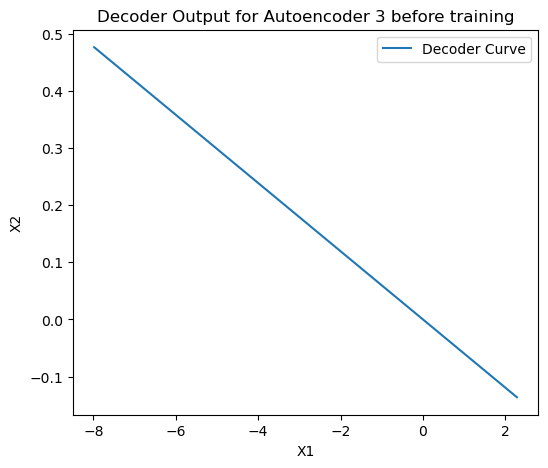

a
OrderedDict([('autoencoder.encoder.0.weight', tensor([[-0.3016,  0.4840],
        [ 0.0896,  0.6710],
        [-0.7068, -0.1923],
        [-0.3226, -0.3060],
        [ 0.1764, -0.4795],
        [ 0.0668,  0.5985],
        [ 0.6610,  0.2083],
        [-0.6340,  0.0822],
        [-0.2533, -0.3853],
        [ 0.2849,  0.2082],
        [ 0.5373,  0.5180],
        [ 0.6785, -0.0859],
        [ 0.1484,  0.1925],
        [ 0.1966, -0.5032],
        [-0.1271, -0.4604],
        [ 0.7023,  0.1633],
        [-0.1346, -0.6179],
        [ 0.2139,  0.6868],
        [ 0.5311,  0.3892],
        [-0.1855, -0.6360]])), ('autoencoder.encoder.0.bias', tensor([-0.0481,  0.3427,  0.4806, -0.3719,  0.6567, -0.3792,  0.4339,  0.7024,
         0.4138,  0.5174, -0.0335, -0.2249, -0.5566, -0.1883,  0.3382, -0.6693,
         0.0653,  0.2677, -0.6071, -0.3131])), ('autoencoder.encoder.2.weight', tensor([[ 0.0429, -0.0985,  0.0762,  0.0153, -0.0261, -0.0866, -0.1188,  0.0523,
          0.1015, -0.1288, -0.0033, -

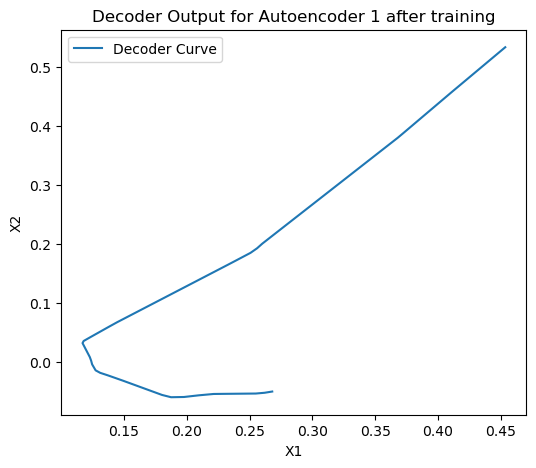

1
OrderedDict([('autoencoder.encoder.0.weight', tensor([[-0.4229,  0.6548],
        [ 0.7343, -0.5580],
        [-0.0364,  0.0498],
        [ 0.1205, -0.1327],
        [ 0.5067,  0.3127],
        [-0.2822, -0.2009],
        [-0.2283, -0.3643],
        [ 0.6619,  0.5282],
        [-0.4332,  0.0354],
        [-0.2911,  0.0271],
        [ 0.2611, -0.1135],
        [ 0.5278, -0.1892],
        [-0.1149,  0.2406],
        [ 0.1279,  0.1468],
        [-0.0906, -0.4916],
        [ 0.0252,  0.1531],
        [ 0.0958, -0.4142],
        [-0.5635,  0.0866],
        [ 0.1874,  0.4248],
        [ 0.8985,  0.1395],
        [-0.5707, -0.5479],
        [-0.0285, -0.5225],
        [-0.3849, -0.2426],
        [-0.1567, -0.6872],
        [ 0.4911,  0.4915],
        [ 0.2727,  0.2096],
        [-0.6452,  0.1945],
        [ 0.2654, -0.1196],
        [-0.4906,  0.6833],
        [-0.0722,  1.0094],
        [-0.0670, -0.6906],
        [-0.4651,  0.1300],
        [-0.0462,  0.1945],
        [ 0.5555,  0.2327],


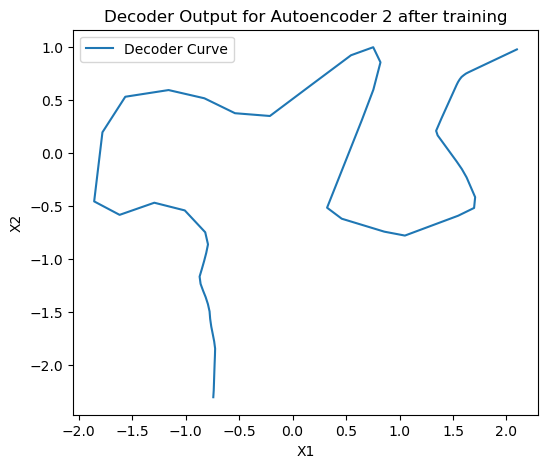

1
OrderedDict([('autoencoder.encoder.weight', tensor([[-0.8738,  0.0524]])), ('autoencoder.decoder.weight', tensor([[-1.1406],
        [ 0.0680]]))])
d
OrderedDict([('autoencoder.encoder.weight', tensor([[-0.8738,  0.0524]])), ('autoencoder.decoder.weight', tensor([[-1.1406],
        [ 0.0680]]))])


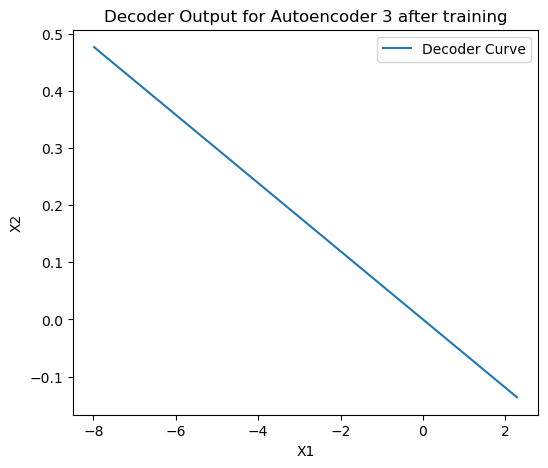

In [39]:
for k,weights in enumerate([initial_weights, final_weights]):
    # Predictions from Decoders (Visualize as Curves)
    print('a')
    print(initial_weights[0],final_weights[0])
    print('b')

    for i, model in enumerate(trained_modules):
        print(k)
        #print(k,weights[i])
        print(trained_modules[model].state_dict())
        print('d')
        trained_modules[model].load_state_dict(weights[i])
        print(trained_modules[model].state_dict())
        latent_space = torch.linspace(-2, 7, steps=100).reshape(-1, 1)
        #print(latent_space)
        #print(trained_modules[model])
        output_space = trained_modules[model].autoencoder.decoder(latent_space).detach().numpy()
    
        plt.figure(figsize=(6, 5))
        plt.plot(output_space[:, 0], output_space[:, 1], label='Decoder Curve')
        if k==0:
            plt.title(f'Decoder Output for Autoencoder {i + 1} before training')
        if k==1:
            plt.title(f'Decoder Output for Autoencoder {i + 1} after training')
        plt.xlabel('X1')
        plt.ylabel('X2')
        plt.legend()
        plt.show()


In [ ]:
n= 4
class MyClass:
    def __init__(self, n):
        for i in range(1, n + 1):
            setattr(self, f"fc{i}", i**2)
obj = MyClass(5)
print(obj.fc1)  # Output: Value of fc1
print(obj.fc2)  # Output: Value of fc2
print(obj.fc3)

In [ ]:
i = 4
setattr(self, f"fc{i}", i**2)

In [ ]:
latent_dim=1
input_dim=2
hidden_channels = [[20,10],[50,50,50],[0]]


for i in range(len(hidden_channels)):
    if hidden_channels[i][0]==0:
        encoder = nn.Linear(input_dim,latent_dim,bias = False)
        decoder = nn.Linear(latent_dim,input_dim,bias = False)       

    else:
        e_modules = []
        d_modules = []
        current_dim = input_dim
        for hidded_channels in hidden_channels[i]:
            e_modules.append(nn.Linear(current_dim, hidded_channels))
            e_modules.append(nn.ReLU())
            current_dim = hidded_channels
        e_modules.append(nn.Linear(current_dim, latent_dim))
        e_modules.append(nn.ReLU())

        encoder = nn.Sequential(*e_modules)
        current_dim = latent_dim
        for hidded_channels in hidden_channels[i][::-1]:
            d_modules.append(nn.Linear(current_dim, hidded_channels))
            d_modules.append(nn.ReLU())
            current_dim = hidded_channels
        decoder = nn.Sequential(*d_modules)
    print(encoder,decoder)